# Tutorial5: Estimation of static and dynamic parameters from visibilities
---
This tutorial demonstrates **joint** estimation of the static envelope and accretion angles from complex visibility measurements. The static envelope is estimated first followed by the dynamic parameter estimation. Similarly to `Tutorial3`, the modes of the underlying SPDE are used to generate a loss manifold and the accretion parameters are estimated as a global minimum to a loss function.

Computing mode dataset
---
This tutorial assumes that a dataset of modes was previously computed. The dataset can be computed using
```
compute_modes_dataset.py --config configs/opening_angles.yaml
```
This script is time-consuming. Altenratively, [download a precomputed mode dataset](https://caltech.box.com/s/yqnzqs7gpeia9kwrf48zfmm2vy8by5lo).  

For information about the dataset parameters see the input configuration file `configs/opening_angles.yaml` and command line arguments `python scripts/compute_modes_dataset.py --h`. For a tutorial overview of the random subspace iteration (RSI) mode computation see `Tutorial2`.


Synthesizing EHT measurements
---
Complex visibility measurements of EHT observations are synthesized using [`eht-imaging`](https://achael.github.io/eht-imaging/). For a complete example demonstrating synthetsis of EHT measurements see `Tutorial4`.

In [1]:
%matplotlib notebook
import pynoisy
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import ehtim as eh
import scipy
import os

Welcome to eht-imaging! v 1.1.1 



In [17]:
"""
Forward model measurements from an ("unknown") envelope and accretion angles. 
"""
nt, ny, nx = 64, 64, 64

# 1. Load EHT array and generate an empty Observation object
array = eh.array.load_txt('../eht_arrays/EHT2025.txt')
obs = pynoisy.observation.empty_eht_obs(array, nt=nt, tint=60.0)

# 2. Generate a stochastic video by modulating an envelope with a Gaussian Random Field.
#    Randomly sample the *true* underlying accretion parameters.
true_params = {'temporal_angle': np.pi/2, 'spatial_angle': -0.95}
diffusion = pynoisy.diffusion.general_xy(ny=ny, nx=nx, opening_angle=true_params['spatial_angle'])
advection = pynoisy.advection.general_xy(ny=ny, nx=nx, opening_angle=true_params['temporal_angle'])
solver = pynoisy.forward.HGRFSolver(advection, diffusion, nt=nt)
grf = solver.run()

# 3. Use the GRF to modulate an envelope and generate a video with pixels as flux densities.
alpha = 2.0
fov = (160.0, 'uas')
total_flux = 0.1 
envelope = pynoisy.envelope.ring(ny=ny, nx=nx, total_flux=total_flux).utils_image.set_fov(fov)
grf = grf.utils_image.set_fov(fov)
movie = pynoisy.forward.modulate(envelope, grf, alpha)
movie = movie.utils_movie.set_time(tstart=obs.tstart, tstop=obs.tstop, units='UTC')

# 4. Generate complex visibility meausrements with thermal noise added. 
obs = pynoisy.observation.observe_same(movie, obs, thermal_noise=True).add_fractional_noise(0.05)
measurements = pynoisy.observation.obs_to_xarray(obs)


Merging 64 frames from MJD 57850 4.00 hr to MJD 57850 15.32 hr
Producing clean visibilities from movie with nfft FT . . . 
Applying Jones Matrices to data . . . 
Applying Jones Matrices to data . . . 
Adding thermal noise to data . . . 
Applying a priori calibration with estimated Jones matrices . . . 


<IPython.core.display.Javascript object>


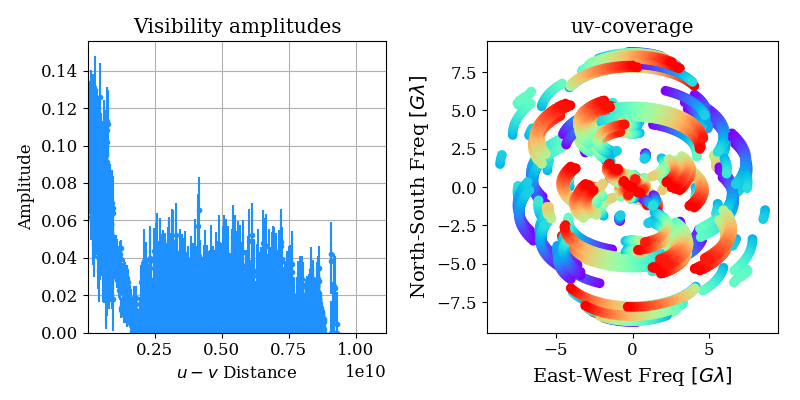

In [18]:
"""
Visualize EHT measurements
"""
fig, axes = plt.subplots(1,2, figsize=(8,4))
obs.plotall('uvdist','amp', axis=axes[0], ebar=True);
pynoisy.observation.plot_uv_coverage(obs, ax=axes[1])
axes[0].set_title('Visibility amplitudes')
axes[1].set_title('uv-coverage')
plt.tight_layout()

In [19]:
"""
Estimate the unknown static envelope. Define an optimization [1] problem using scipy LinearOperators [1,2].
LinearOperators implement forward operation as standard multiplication: `output = Op * input` 
or as `output = Op(input)`. The adjoint operation can be accessed by `Op.H * output`. 
For more information see: pynoisy/operators.py or the references below.

References
----------
[1] https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html
[2] https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.LinearOperator.html
[3] https://pylops.readthedocs.io/en/latest/
"""
# Data-fit Operators
ehtOp = pynoisy.operators.ObserveOp(obs, movie.coords)
modulateOp = pynoisy.operators.ModulateOp(xr.ones_like(grf))
forwardOp = ehtOp * modulateOp
data_ops = pynoisy.operators.L2LossOp(measurements.vis, forwardOp, measurements.sigma)

# Regularization Operators (see: pynoisy.operators for other Ops e.g. STVRegOp, L2RegOp)
prior_image = pynoisy.envelope.gaussian(ny, nx, fov=fov, fwhm=80.0, total_flux=total_flux)
reg_ops = [pynoisy.operators.FluxRegOp(prior=total_flux, weight=1e2), 
           pynoisy.operators.MEMRegOp(prior=prior_image, weight=3e4)]


# Define and solve the optimization problem 
x0 = np.zeros_like(envelope.data.ravel())
loss = pynoisy.operators.Loss(data_ops=data_ops, reg_ops=reg_ops)
output = scipy.optimize.minimize(
    loss, x0=x0, jac=loss.jac, method='L-BFGS-B', bounds=[(0,None) for _ in range(x0.size)], 
    options={'maxiter': 100, 'disp': True}
)
envelope_estimate = xr.DataArray(output['x'].reshape(ny, nx), coords=envelope.coords)

<IPython.core.display.Javascript object>


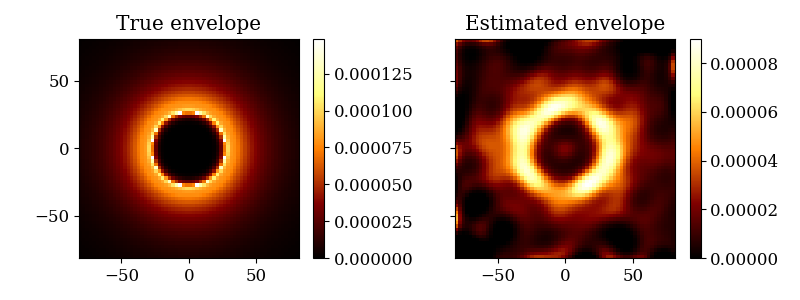

In [20]:
fig, axes = plt.subplots(1,2, figsize=(8,3), sharey=True)
envelope.plot(ax=axes[0], cmap='afmhot', add_labels=False)
envelope_estimate.plot(ax=axes[1], cmap='afmhot', add_labels=False)
axes[0].set_title('True envelope')
axes[1].set_title('Estimated envelope')
axes[0].set_aspect('equal')
axes[1].set_aspect('equal')
plt.tight_layout()

In [21]:
"""
Load multi-file dataset with xarray and dask for parallel computations.
Replace `mode_directory` with the current directory of the modes
"""
mode_directory = '../datasets/opening_angles.09-Apr-2021-18:48:05/modes/'
modes = xr.open_mfdataset(os.path.join(mode_directory, 'mode*.nc'))

# Linearization results in estimation of the "dynamic portion" of the measurements
measurements_dynamics = (measurements['vis'] - envelope_estimate.utils_observe.block_observe_same_nonoise(obs))

# Generate subspace of "augmented" modes multiplied by the envelope estimate
eigenvectors = modes.eigenvectors.utils_image.set_fov(fov).utils_movie.set_time(tstart=obs.tstart, tstop=obs.tstop)
subspace = eigenvectors * modes.eigenvalues * envelope_estimate

In [ ]:
"""
Compute the 2D loss manifold, note this may take a while and take up resources. 
Takes ~8 minutes for 60 modes of size 64x64x64 with 24 CPU cores.
"""
loss = pynoisy.inverse.compute_visibilities_loss(subspace, measurements_dynamics, obs, damp=2e-3)

[##############                          ] | 35% Completed |  3min 54.9s

<IPython.core.display.Javascript object>


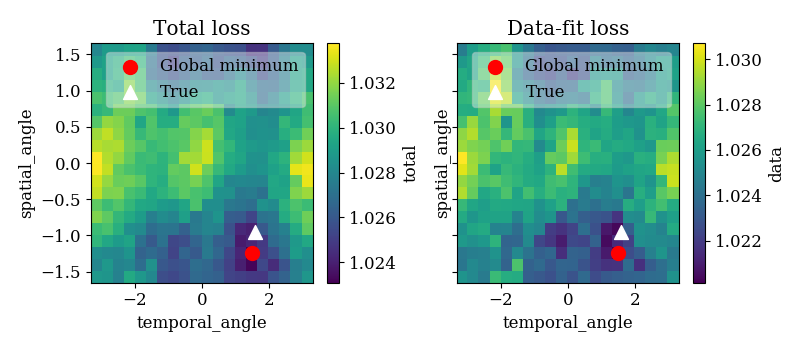

In [17]:
"""
Visualize the data-fit manifolds and true parameters
"""
fig, axes = plt.subplots(1,2, figsize=(8,3.5), sharey=True)
loss.total.utils_loss.plot2d(ax=axes[0], true=true_params)
loss.data.utils_loss.plot2d(ax=axes[1], true=true_params)
axes[0].set_title('Total loss')
axes[1].set_title('Data-fit loss');